# Processing Wikipedia articles

This notebook processes the downloaded and decompressed Wikipedia articles and should therefore be run __after__ ``download_wikipedia.ipynb``. Distance to nearest POI for each category and spatially weighted text based features will be created.

### Import packages

In [1]:
import os
import gc
import json
import re
from collections import Counter
import warnings
warnings.filterwarnings(action="ignore")

from tqdm.notebook import tqdm

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from geopy import distance

import multiprocessor_wiki

Definde constants.

- ``PATH``: Path to the base data folder
- ``CPU_CORES``: How many cores to use to process data, default=all
- ``MAX_DIST``: Maximum radius around each house for Wikipedia articles to be considered for text features

In [2]:
PATH = "C:/Users/Tim/.keras/datasets/wikipedia_real_estate/"
# CPU_CORES = os.cpu_count()
CPU_CORES = 11
MAX_DIST = 6500  # max distance to consider in m
WEIGHTING = True  # whether to employ weighting strategy for subdocuments
MEAN = False
MIN_DF = 0.02

Load data.

In [3]:
with open(PATH+"wikipedia/wikipedia_selected.ndjson") as fin:
    data_loaded = json.load(fin)

In [4]:
df = pd.DataFrame(data_loaded).rename(columns={0: "name", 1: "coords", 2: "templates", 3: "text",
                                               4: "wikilinks", 5: "ext_links", 6: "text_length"})
print(df.shape)
df.head(5)

(2407, 7)


,name,coords,templates,text,wikilinks,ext_links,text_length
0,Washington County Courthouse (Pennsylvania),"[40.170449999999995, -80.24580277777778]","{'name': 'Washington County Courthouse', 'desi...",The Washington County Courthouse is located in...,"[Washington, Pennsylvania, Frederick J. Osterl...",[http://www.washcolandmarks.com/landmark_regis...,1257
1,Wild Things Park,"[40.15416666666667, -80.28361111111111]","{'stadium_name': 'Wild Things Park', 'nickname...","Wild Things Park is a 3,200-seat multi-purpose...","[File:Falconi Field, now known as CONSOL Energ...",[http://www.consolenergy.com/Powering/Partners...,4461
2,Thackeray Hall,"[40.444316666666666, -79.95726388888889]","{'name': 'Thackeray Hall', 'nrhp_type': 'cp', ...",Thackeray Hall is an academic building of the ...,"[University of Pittsburgh, Schenley Farms Hist...",[https://web.archive.org/web/20090628170337/ht...,2357
3,Immaculate Heart of Mary Church (Pittsburgh),"[40.45638888888889, -79.96777777777778]","{'name': 'Immaculate Heart of Mary Church', 'n...","Immaculate Heart of Mary Church in Pittsburgh,...","[William P. Ginther, Polish language, Roman Ca...",[http://www.phlf.org/wp-content/uploads/2007/0...,2978
4,St. Stanislaus Kostka Church (Pittsburgh),"[40.45232222222222, -79.98361111111112]",{'name': 'St. Stanislaus Kostka Roman Catholic...,"St. Stanislaus Kostka Church in Pittsburgh, Pe...","[Pittsburgh, Pennsylvania, Frederick C. Sauer,...",[http://www.phlf.org/wp-content/uploads/2007/0...,5254


Explore keywords.

In [5]:
df.loc[0, "templates"]

{'name': 'Washington County Courthouse',
 'designated_other1_name': 'Washington County History  &  Landmarks Foundation Landmark',
 'designated_other1_link': 'Washington County History  &  Landmarks Foundation',
 'designated_other1_color': '#f5dc0f',
 'image': 'Washington County Courthouse (Pennsylvania) south.jpg',
 'caption': 'The Courthouse in January 2015',
 'location': '1 South Main Street, < br/ > Washington, Pennsylvania',
 'locmapin': 'Pennsylvania',
 'built': '1900',
 'architect': 'Frederick J. Osterling',
 'architecture': 'Beaux-Arts',
 'added': 'July 30, 1974',
 'refnum': '74001812 < ref name= " NRIS " >  < /ref >'}

In [6]:
keywords = [key for dic in df["templates"] if dic is not None for key in dic]

In [7]:
Counter(keywords).most_common(10)

[('name', 1675),
 ('image', 1057),
 ('location', 867),
 ('subdivision_type1', 600),
 ('subdivision_name1', 592),
 ('subdivision_type2', 584),
 ('subdivision_name2', 584),
 ('map_caption', 561),
 ('subdivision_type', 535),
 ('settlement_type', 529)]

Explore Wikilinks.

In [8]:
df.loc[0, "wikilinks"]

['Washington, Pennsylvania',
 'Frederick J. Osterling',
 'Beaux-Arts architecture',
 'Washington, Pennsylvania',
 'National Register of Historic Places',
 'historic public landmark',
 'Washington County History  &  Landmarks Foundation',
 'Washington County History  &  Landmarks Foundation',
 'Walter Mondale',
 'Ted Kennedy',
 'National Register of Historic Places listings in Washington County, Pennsylvania',
 'List of state and county courthouses in Pennsylvania',
 'Category:Courthouses on the National Register of Historic Places in Pennsylvania',
 'Category:Government buildings completed in 1900',
 'Category:Beaux-Arts architecture in Pennsylvania',
 'Category:County courthouses in Pennsylvania',
 'Category:Buildings and structures in Washington County, Pennsylvania',
 'Category:Frederick J. Osterling buildings',
 'Category:Washington, Pennsylvania',
 'Category:National Register of Historic Places in Washington County, Pennsylvania']

In [9]:
wikilinks = [category for lst in df["wikilinks"] if lst is not None for category in lst if "Category:" in category]
Counter(wikilinks).most_common(150)

[('Category:Pittsburgh metropolitan area', 290),
 ('Category:Pittsburgh History  &  Landmarks Foundation Historic Landmarks',
  218),
 ('Category:National Register of Historic Places in Pittsburgh', 184),
 ('Category:Unincorporated communities in Pennsylvania', 127),
 ('Category:Road bridges in Pennsylvania', 104),
 ('Category:Buildings and structures in Pittsburgh', 102),
 ('Category:Houses on the National Register of Historic Places in Pennsylvania',
  95),
 ('Category:National Register of Historic Places in Washington County, Pennsylvania',
  92),
 ('Category:Education in Pittsburgh area', 89),
 ('Category:Public high schools in Pennsylvania', 88),
 ('Category:Neighborhoods in Pittsburgh', 86),
 ('Category:Boroughs in Allegheny County, Pennsylvania', 86),
 ('Category:Census-designated places in Pennsylvania', 76),
 ('Category:Rivers of Pennsylvania', 69),
 ('Category:City of Pittsburgh historic designations', 68),
 ('Category:Historic districts on the National Register of Historic P

## Creating distance based features

Create category dfs

In [10]:
observations = []
for index, row in df.iterrows():
    if "Category:Airports in Pennsylvania" in row["wikilinks"]:
        observations.append(row)
        
len(observations)

12

In [11]:
wikilinks[:10]

['Category:Courthouses on the National Register of Historic Places in Pennsylvania',
 'Category:Government buildings completed in 1900',
 'Category:Beaux-Arts architecture in Pennsylvania',
 'Category:County courthouses in Pennsylvania',
 'Category:Buildings and structures in Washington County, Pennsylvania',
 'Category:Frederick J. Osterling buildings',
 'Category:Washington, Pennsylvania',
 'Category:National Register of Historic Places in Washington County, Pennsylvania',
 'Category:Baseball venues in Pennsylvania',
 'Category:Soccer venues in Pennsylvania']

In [12]:
categories_strs = ["historic", "bridge", "river", "tourist attraction", "skyscraper", "park",
                   "universit", "museum", "railway station", "shopping mall", "sports venue",
                   "church", "music venue", "librar", "demolished", "theatre", "airport",
                   "metropolitan", "unincorporated", "education", "tourist attraction",
                   "high school", "public", "defunct", "golf", "transportation"]
categories_dict = {category:[] for category in categories_strs}

In [13]:
for index, row in df.iterrows():
    for category in categories_strs:
        for cat_link in [link for link in row["wikilinks"] if "Category:" in link]:
            if category in cat_link.lower():  # make lowercase
                categories_dict[category].append(row)
                break

In [14]:
categories_dfs = {category:[] for category in categories_strs}
for category in categories_dict:
    category_df = pd.DataFrame(data=categories_dict[category])
    categories_dfs[category] = category_df
    print(f"{category}: {category_df.shape}")

historic: (575, 7)
bridge: (133, 7)
river: (281, 7)
tourist attraction: (136, 7)
skyscraper: (51, 7)
park: (74, 7)
universit: (174, 7)
museum: (69, 7)
railway station: (84, 7)
shopping mall: (28, 7)
sports venue: (53, 7)
church: (61, 7)
music venue: (21, 7)
librar: (36, 7)
demolished: (49, 7)
theatre: (21, 7)
airport: (20, 7)
metropolitan: (301, 7)
unincorporated: (139, 7)
education: (222, 7)
high school: (108, 7)
public: (135, 7)
defunct: (70, 7)
golf: (27, 7)
transportation: (51, 7)


In [15]:
categories_dfs["theatre"].head(10)

,name,coords,templates,text,wikilinks,ext_links,text_length
163,"Strand Theater (Zelienople, Pennsylvania)","[40.7962, -80.1374]","{'name': 'Strand Theater', 'image': 'Strand1.J...","The Strand Theater is a performing arts, film ...","[Zelienople, Pennsylvania, Pennsylvania, Unite...","[http://www.thestrandtheater.org/, http://www....",3068
228,Carnegie Mellon School of Drama,"[40.443772, -79.943211]",None,thumb|Main atrium of the Purnell Center for th...,[File:Carnegie Mellon School of Drama Interior...,[https://www.hollywoodreporter.com/lists/5-bes...,7723
398,Carnegie Library of Homestead,"[40.40708055555555, -79.90297777777778]",{'library_name': 'Carnegie Library of Homestea...,The Carnegie Library of Homestead is a public ...,"[File:CarnegieLibraryofHomestead.jpg, United S...","[http://www.CarnegieofHomestead.org, http://ww...",6024
432,Friday Nite Improvs,"[40.44416, -79.95312]",None,thumb|right|The Studio Theatre in the basement...,"[File:CathedraloL blackbox.jpg, Cathedral of L...",[http://www.pittsburghcitypaper.ws/gyrobase/Co...,10673
859,Garden Theater,"[40.455488888888894, -80.00726666666667]","{'name': 'Garden Theater', 'PAhistoric_type': ...","The Garden Theater (or Garden Theatre) is a 1,...","[Pittsburgh, Pennsylvania, Thomas H. Scott, Be...",[http://www.post-gazette.com/pg/07140/786960-4...,3747
906,City Theatre (Pittsburgh),"[40.429267, -79.985125]","{'name': 'City Theatre', 'designation1': 'PHLF...",City Theatre is a professional theatre company...,"[South Side Flats, Pittsburgh, Pennsylvania, U...",[http://www.phlf.org/wp-content/uploads/2007/0...,2931
907,Quantum Theatre,"[40.462939, -79.924045]","{'name': 'Quantum Theatre', 'image': 'Quantum ...",Quantum Theatre is a professional theatre comp...,"[Pittsburgh, Pennsylvania, Pittsburgh, Theatre...","[http://www.quantumtheatre.com/about/staff/, h...",3050
994,Stephen Foster Memorial,"[40.44382, -79.95275]","{'name': 'Stephen Collins Foster Memorial', 'n...",The Stephen Collins Foster Memorial is a perfo...,"[University of Pittsburgh, Pittsburgh, Pennsyl...","[http://search.pahistoricalmarkers.com/, http:...",13888
1005,Scotch'n'Soda Theatre,"[40.44333333333333, -79.94166666666668]","{'name': 'Scotch'n'Soda Theatre', 'logo': 'Sco...",Scotch'n'Soda is a student-run theatre organiz...,"[Carnegie Mellon University, Scotch'n'Soda#Boa...","[http://www.snstheatre.org, https://books.goog...",14167
1118,Pittsburgh Playhouse,"[40.43959, -79.99989]","{'name': 'Pittsburgh Playhouse', 'image': 'Pit...",Pittsburgh Playhouse is Point Park University'...,"[Forbes Avenue, Pittsburgh, Pennsylvania, Unit...","[http://www.pittsburghplayhouse.com, http://ww...",13989


Read structured data.

In [16]:
df_structured = pd.read_csv(PATH + "structured_preprocessed.csv")  # read structured data

In [17]:
df_structured.shape

(9554, 65)

Add distance based features to the structured data. For each house, the distance to the nearest POI of each category is calculated and added as a feature. Another feature to be added is the amount of POI of each category in a 2500m radius around the house.

In [18]:
df_structured_features = multiprocessor_wiki.process_dist_features(df_structured, categories_dfs, CPU_CORES)

  0%|          | 0/100 [00:00<?, ?it/s]

If already processed, read processed data.

In [19]:
# df_structured_features = pd.read_csv(PATH + "structured_wiki_category_features.csv")

In [20]:
df_structured_features.head(10)

,_id,PROPERTYZIP,MUNICODE,SCHOOLCODE,NEIGHCODE,LOTAREA,SALEDATE,SALEPRICE,FAIRMARKETTOTAL,STORIES,...,high school_dist,high school_count,public_dist,public_count,defunct_dist,defunct_count,golf_dist,golf_count,transportation_dist,transportation_count
0,536102,15219,103,47,10301,2875,01-31-2018,287000.0,159000,2.0,...,646.211908,4,993.947917,10,517.699850,14,3654.869381,0,910.904485,5
1,197251,15241,950,42,95002,17193,09-02-2017,299900.0,259500,2.0,...,1356.822566,1,1356.822566,1,9127.889947,0,6210.239877,0,5248.021671,0
2,25219,15146,879,18,87910,22264,03-22-2017,190000.0,214900,2.0,...,3340.901141,0,3340.901141,0,1133.283586,1,11845.526480,0,6003.343808,0
3,197755,15236,873,44,87302,7800,05-09-2017,225000.0,155000,2.0,...,1918.186873,2,1918.186873,1,1831.468503,2,7576.960841,0,3950.374941,0
4,198593,15015,809,27,80902,43734,06-28-2019,249000.0,208800,2.0,...,4211.043296,0,1455.785244,1,13266.442574,0,21196.013740,0,9357.397493,0
5,532924,15212,127,47,12703,5000,05-25-2016,113000.0,84300,2.0,...,270.510903,1,270.510903,4,270.510903,7,8006.652249,0,2587.035978,0
6,198384,15136,919,24,91903,9664,10-30-2015,189900.0,169200,1.0,...,599.370206,1,599.370206,1,3972.673023,0,9015.869977,0,4286.475014,0
7,198694,15237,927,27,92703,12162,11-06-2019,310000.0,257800,2.0,...,2039.286700,1,2039.286700,2,4648.043348,0,11673.441446,0,8344.857679,0
8,198744,15227,874,4,87402,6695,03-13-2018,165000.0,144200,1.5,...,800.919649,2,800.919649,2,2921.479813,0,3399.838705,0,4095.874034,0
9,199198,15139,845,33,84501,12050,08-24-2018,380000.0,320000,2.0,...,935.704859,1,935.704859,1,9131.859699,0,452.914362,15,2780.160495,0


Save structured data with added distance based features.

In [21]:
df_structured_features.to_csv(PATH + "structured_wiki_category_features.csv", index=False)

## Visualize categories

Create boxplot for distance to nearest for __GIS__ data

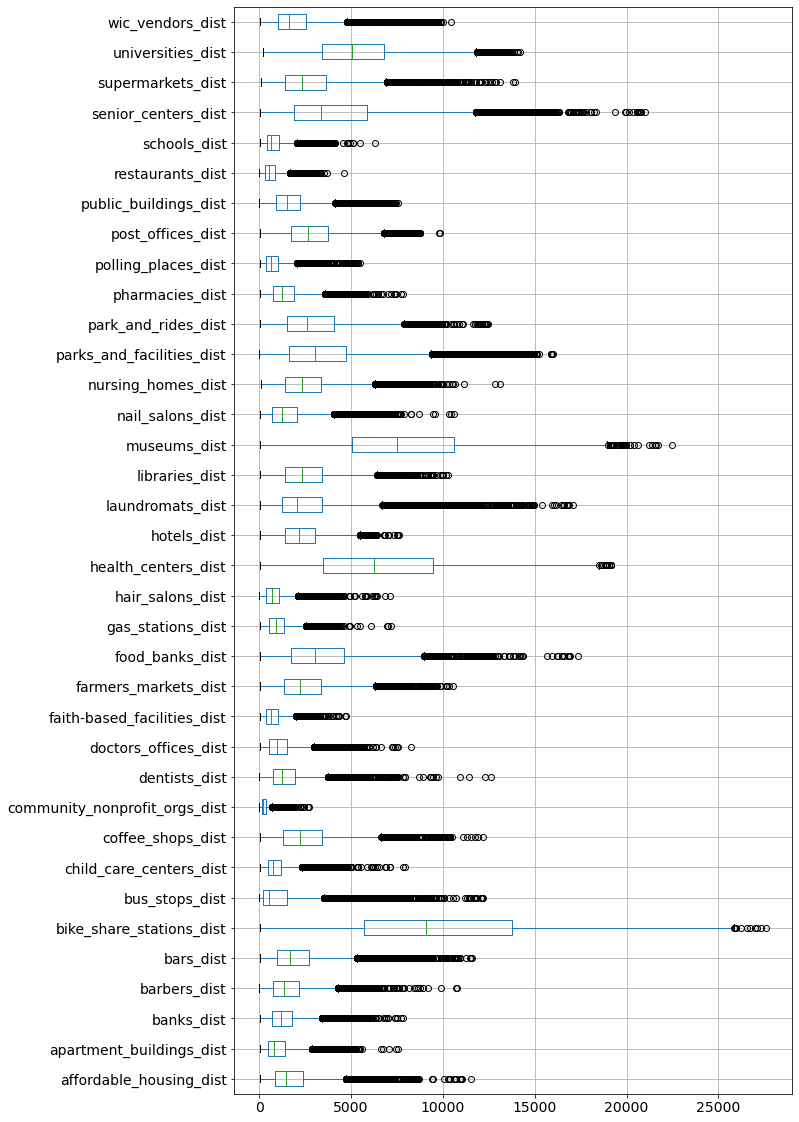

In [22]:
structured_gis_features = pd.read_csv(PATH+f"structured_gis_category_features_1500_radius.csv")
dist_cols = [col for col in list(structured_gis_features) if "_dist" in col]
boxplot = structured_gis_features.boxplot(column=dist_cols, figsize=(10,20), vert=False)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("visualizations/boxplot_gis_category_dist.png", bbox_inches="tight")
plt.show()

Create boxplot to show distribution of nearest POIs for each category for __Wikipedia__ data.

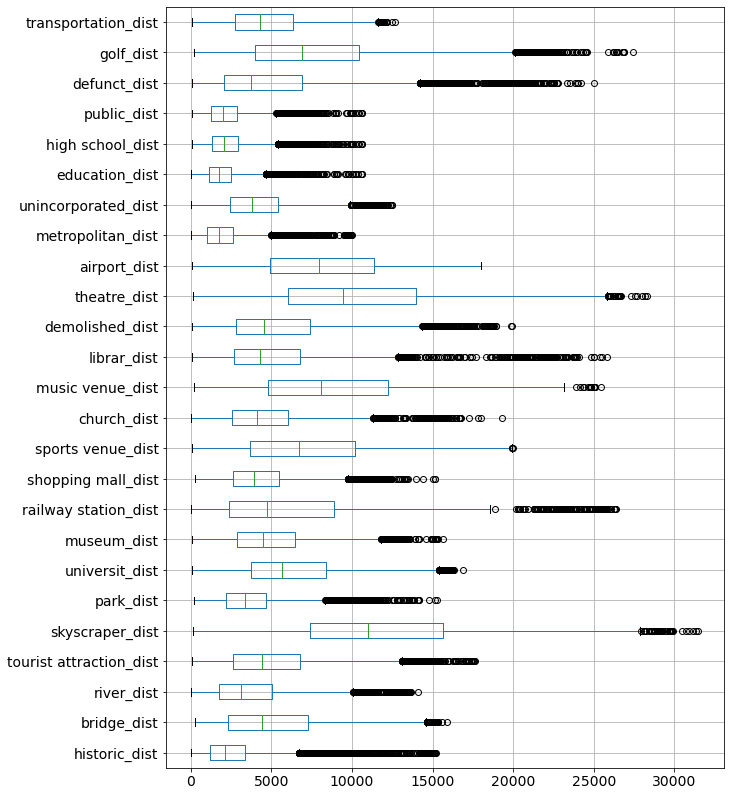

In [23]:
df_structured_features = pd.read_csv(PATH+"structured_wiki_category_features.csv")
dist_cols = [col for col in list(df_structured_features.columns) if "_dist" in col]
boxplot = df_structured_features.boxplot(column=dist_cols, figsize=(10,14), vert=False)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("visualizations/boxplot_wiki_category_dist.png", bbox_inches="tight")
plt.show()

## Create text based features

Add whitespace after "Category:" template, so that the first word of each category can be added to the corpus.

In [24]:
string = "[[Category:Washington, Pennsylvania]]"
re.sub(r"([cC]ategory:)([a-zA-z]+)", r"\1 \2", string)

'[[Category: Washington, Pennsylvania]]'

In [25]:
df["text"] = df["text"].apply(lambda x: re.sub(r"([cC]ategory:)([a-zA-z]+)", r"\1 \2", x))

Make custom stopword list.

In [26]:
custom_stopwords = stopwords.words("english")
custom_stopwords.extend(["ref", "ref ref", "ref name", "name", "also", "per", "one", "two",
                         "three", "four", "five", "six", "seven", "eight", "nine", "ten",
                         "eleven", "twelve"])

Tokenize, create 2-grams and filter out top 2% used words.

In [27]:
token = RegexpTokenizer(r'[a-zA-Z][a-zA-Z][a-zA-Z]+')  # only keep words with minimum length of 3
vectorizer = CountVectorizer(tokenizer=token.tokenize, stop_words=custom_stopwords, ngram_range=(1,2),
                             min_df=MIN_DF)

Create term frequency matrix.

In [28]:
count_matrix = vectorizer.fit_transform(df["text"])
count_array = count_matrix.toarray()
count_matrix.shape

(2407, 3108)

Save word count matrix for articles.

In [29]:
count_df = pd.DataFrame(data=count_array)
count_df.columns = vectorizer.get_feature_names()
count_df.insert(0, "article_title", df["name"])
count_df.to_csv(PATH+"wikipedia/wikipedia_article_wordcounts.csv", index=False)
count_df.head()

,article_title,abandoned,ability,able,academic,academic achievement,academic performance,academics,academy,accept,...,yielding,yielding student,york,york city,youghiogheny,youghiogheny river,young,youth,zip,zip code
0,Washington County Courthouse (Pennsylvania),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wild Things Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Thackeray Hall,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Immaculate Heart of Mary Church (Pittsburgh),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,St. Stanislaus Kostka Church (Pittsburgh),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Show words with counts for first article.

In [30]:
x = [(word, count) for i, (count, word) in enumerate(zip(count_array[0], vectorizer.get_feature_names())) if count > 0]

print(*x, sep=", ")

('april', 1), ('architecture', 1), ('architecture pennsylvania', 1), ('arts', 1), ('buildings', 3), ('buildings category', 1), ('buildings completed', 1), ('buildings structures', 1), ('campaign', 1), ('category', 8), ('category buildings', 1), ('category national', 1), ('completed', 1), ('completed category', 1), ('county', 7), ('county history', 1), ('county pennsylvania', 3), ('courthouse', 2), ('democratic', 1), ('designated', 1), ('designated historic', 1), ('downtown', 1), ('external', 1), ('external links', 1), ('form', 1), ('form category', 1), ('foundation', 1), ('frederick', 1), ('government', 1), ('historic', 5), ('historic places', 4), ('history', 1), ('history landmarks', 1), ('july', 1), ('kennedy', 1), ('landmark', 1), ('landmarks', 1), ('landmarks foundation', 1), ('links', 1), ('links national', 1), ('list', 1), ('listed', 1), ('listed national', 1), ('listings', 1), ('located', 1), ('national', 5), ('national register', 5), ('nomination', 1), ('nomination form', 1), (

Show the 100 most common words.

In [31]:
freqs = zip(vectorizer.get_feature_names(), count_array.sum(axis=0))
print(sorted(freqs, key=lambda x: -x[1])[:100])

[('school', 17739), ('pennsylvania', 17286), ('pittsburgh', 13005), ('category', 11209), ('district', 7781), ('county', 6785), ('state', 6473), ('education', 5565), ('area', 4733), ('high', 4507), ('students', 4088), ('allegheny', 4008), ('school district', 4006), ('township', 3982), ('pennsylvania category', 3840), ('center', 3661), ('building', 3627), ('grade', 3454), ('historic', 3450), ('high school', 3416), ('states', 3332), ('united', 3294), ('city', 3252), ('national', 3250), ('new', 3242), ('year', 3213), ('age', 3155), ('united states', 3133), ('university', 3069), ('department', 2994), ('years', 2926), ('history', 2866), ('borough', 2822), ('county pennsylvania', 2819), ('public', 2808), ('first', 2772), ('basic', 2749), ('schools', 2726), ('population', 2707), ('level', 2680), ('located', 2679), ('park', 2631), ('references', 2595), ('station', 2391), ('american', 2274), ('washington', 2273), ('bridge', 2244), ('places', 2231), ('income', 2227), ('north', 2217), ('river', 22

In [32]:
feature_names = vectorizer.get_feature_names()
print(feature_names[:10])
len(feature_names)

['abandoned', 'ability', 'able', 'academic', 'academic achievement', 'academic performance', 'academics', 'academy', 'accept', 'accept credits']


3108

Create idf vector.

In [33]:
transformer = TfidfTransformer(use_idf=True)
tf_idf_matrix = transformer.fit_transform(count_matrix)
words_idf = {word:val for (word, val) in zip(feature_names, transformer.idf_)}
words_idf

{'abandoned': 4.171431289587453,
 'ability': 4.797567759864437,
 'able': 4.332204510175204,
 'academic': 3.229723744729174,
 'academic achievement': 4.1325914562711885,
 'academic performance': 4.709014362522993,
 'academics': 4.42984297973912,
 'academy': 3.9502698994772336,
 'accept': 4.40452517175483,
 'accept credits': 4.581859187037745,
 'access': 3.229723744729174,
 'access activities': 4.612164536533075,
 'accessed': 3.8520778732980197,
 'accessible': 4.612164536533075,
 'accommodate': 4.779218621196241,
 'according': 2.342420549728271,
 'according national': 4.8353080878472845,
 'according pennsylvania': 4.297915436696572,
 'according report': 4.643417080037179,
 'according united': 2.867657952155565,
 'account': 4.5670441012526055,
 'achieve': 4.854726173704385,
 'achieved': 4.113722971966805,
 'achieved ayp': 4.65941742138362,
 'achievement': 3.9662702408236745,
 'achievement report': 4.761200115693562,
 'acquired': 3.7303060010804034,
 'acre': 4.627668723069039,
 'acres': 3.

Create text based features by filtering all articles in ``MAX_DIST`` radius, weighing tf vectors by distance and calculating the mean for every word.

In [34]:
df.reset_index(drop=True, inplace=True)  # make sure index is from 0 to n-1
df_structured_tf = multiprocessor_wiki.process_text_features(df_structured, df, count_array, feature_names,
                                                             MAX_DIST, CPU_CORES, WEIGHTING, MEAN)

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
rows_before = df_structured_tf.shape[0]
print(f"Number of rows: {rows_before}")
df_structured_tf.head(10)

Number of rows: 9554


,_id,PROPERTYZIP,MUNICODE,SCHOOLCODE,NEIGHCODE,LOTAREA,SALEDATE,SALEPRICE,FAIRMARKETTOTAL,STORIES,...,yielding student,york,york city,youghiogheny,youghiogheny river,young,youth,zip,zip code,article_count
0,362058,15212,126,47,12603,5329,10-27-2017,113000.0,69200,1.0,...,0.135761,92.508501,19.431320,1.468672,1.330256,39.862994,13.685687,21.222076,16.779576,775
1,544290,15017,946,36,94601,10800,09-27-2016,320000.0,269900,2.0,...,0.000000,1.001622,0.249194,0.000000,0.000000,0.000000,2.749373,2.130482,1.908684,31
2,314083,15090,935,3,93503,114476,03-25-2017,545000.0,450000,1.0,...,1.756682,0.000000,0.000000,0.000000,0.000000,0.000000,0.144138,0.860923,0.860923,20
3,314280,15241,950,42,95003,43197,06-09-2016,315000.0,274000,2.0,...,2.671843,1.446329,0.513478,0.000000,0.000000,0.380497,0.513478,0.537569,0.528853,53
4,314812,15239,880,31,88006,12390,01-31-2017,174900.0,154100,2.0,...,2.003283,0.129308,0.000000,0.073750,0.000000,0.073750,0.117636,0.000000,0.000000,13
5,315579,15143,921,32,92102,10081,03-02-2015,300000.0,244600,2.0,...,3.407309,4.025697,0.000954,0.769209,0.769209,2.519963,1.662487,1.022760,1.022760,57
6,315587,15235,934,30,93401,10257,05-15-2017,172500.0,144700,2.0,...,3.883454,3.566293,1.175168,0.535499,0.000000,1.743717,2.405588,0.716703,0.364008,49
7,362804,15102,876,5,87603,10920,07-11-2016,250000.0,217800,2.0,...,2.746174,1.212427,0.116219,0.000000,0.000000,0.630343,0.116219,0.647390,0.647390,68
8,315758,15108,939,24,93903,54189,09-28-2018,199900.0,174700,1.0,...,1.649716,1.494237,0.000000,0.308177,0.000000,0.602306,1.240463,0.364361,0.364361,56
9,315868,15133,837,35,83702,6569,05-12-2017,143000.0,117900,2.0,...,1.699028,2.557618,0.610149,19.527779,17.013978,0.963810,1.470704,2.205259,1.785977,54


Omit houses with less than 3 articles in range and save omitted observations.

In [36]:
omitted_df = df_structured_tf[df_structured_tf["article_count"] < 3]
omitted_df.to_csv(PATH + f"structured_wiki_text_features_OMITTED_{str(MAX_DIST)}.csv", index=False)

In [37]:
df_structured_tf = df_structured_tf.dropna()
print(f"Number of houses with less than 3 articles in {str(MAX_DIST/1000)} km radius: {rows_before - df_structured_tf.shape[0]}")
df_structured_tf.head(10)

Number of houses with less than 3 articles in 6.5 km radius: 0


,_id,PROPERTYZIP,MUNICODE,SCHOOLCODE,NEIGHCODE,LOTAREA,SALEDATE,SALEPRICE,FAIRMARKETTOTAL,STORIES,...,yielding student,york,york city,youghiogheny,youghiogheny river,young,youth,zip,zip code,article_count
0,362058,15212,126,47,12603,5329,10-27-2017,113000.0,69200,1.0,...,0.135761,92.508501,19.431320,1.468672,1.330256,39.862994,13.685687,21.222076,16.779576,775
1,544290,15017,946,36,94601,10800,09-27-2016,320000.0,269900,2.0,...,0.000000,1.001622,0.249194,0.000000,0.000000,0.000000,2.749373,2.130482,1.908684,31
2,314083,15090,935,3,93503,114476,03-25-2017,545000.0,450000,1.0,...,1.756682,0.000000,0.000000,0.000000,0.000000,0.000000,0.144138,0.860923,0.860923,20
3,314280,15241,950,42,95003,43197,06-09-2016,315000.0,274000,2.0,...,2.671843,1.446329,0.513478,0.000000,0.000000,0.380497,0.513478,0.537569,0.528853,53
4,314812,15239,880,31,88006,12390,01-31-2017,174900.0,154100,2.0,...,2.003283,0.129308,0.000000,0.073750,0.000000,0.073750,0.117636,0.000000,0.000000,13
5,315579,15143,921,32,92102,10081,03-02-2015,300000.0,244600,2.0,...,3.407309,4.025697,0.000954,0.769209,0.769209,2.519963,1.662487,1.022760,1.022760,57
6,315587,15235,934,30,93401,10257,05-15-2017,172500.0,144700,2.0,...,3.883454,3.566293,1.175168,0.535499,0.000000,1.743717,2.405588,0.716703,0.364008,49
7,362804,15102,876,5,87603,10920,07-11-2016,250000.0,217800,2.0,...,2.746174,1.212427,0.116219,0.000000,0.000000,0.630343,0.116219,0.647390,0.647390,68
8,315758,15108,939,24,93903,54189,09-28-2018,199900.0,174700,1.0,...,1.649716,1.494237,0.000000,0.308177,0.000000,0.602306,1.240463,0.364361,0.364361,56
9,315868,15133,837,35,83702,6569,05-12-2017,143000.0,117900,2.0,...,1.699028,2.557618,0.610149,19.527779,17.013978,0.963810,1.470704,2.205259,1.785977,54


Mean of in range articles

In [38]:
df_structured_tf["article_count"].mean()

144.66631777266068

In [39]:
df_structured_tf.head(10)

,_id,PROPERTYZIP,MUNICODE,SCHOOLCODE,NEIGHCODE,LOTAREA,SALEDATE,SALEPRICE,FAIRMARKETTOTAL,STORIES,...,yielding student,york,york city,youghiogheny,youghiogheny river,young,youth,zip,zip code,article_count
0,362058,15212,126,47,12603,5329,10-27-2017,113000.0,69200,1.0,...,0.135761,92.508501,19.431320,1.468672,1.330256,39.862994,13.685687,21.222076,16.779576,775
1,544290,15017,946,36,94601,10800,09-27-2016,320000.0,269900,2.0,...,0.000000,1.001622,0.249194,0.000000,0.000000,0.000000,2.749373,2.130482,1.908684,31
2,314083,15090,935,3,93503,114476,03-25-2017,545000.0,450000,1.0,...,1.756682,0.000000,0.000000,0.000000,0.000000,0.000000,0.144138,0.860923,0.860923,20
3,314280,15241,950,42,95003,43197,06-09-2016,315000.0,274000,2.0,...,2.671843,1.446329,0.513478,0.000000,0.000000,0.380497,0.513478,0.537569,0.528853,53
4,314812,15239,880,31,88006,12390,01-31-2017,174900.0,154100,2.0,...,2.003283,0.129308,0.000000,0.073750,0.000000,0.073750,0.117636,0.000000,0.000000,13
5,315579,15143,921,32,92102,10081,03-02-2015,300000.0,244600,2.0,...,3.407309,4.025697,0.000954,0.769209,0.769209,2.519963,1.662487,1.022760,1.022760,57
6,315587,15235,934,30,93401,10257,05-15-2017,172500.0,144700,2.0,...,3.883454,3.566293,1.175168,0.535499,0.000000,1.743717,2.405588,0.716703,0.364008,49
7,362804,15102,876,5,87603,10920,07-11-2016,250000.0,217800,2.0,...,2.746174,1.212427,0.116219,0.000000,0.000000,0.630343,0.116219,0.647390,0.647390,68
8,315758,15108,939,24,93903,54189,09-28-2018,199900.0,174700,1.0,...,1.649716,1.494237,0.000000,0.308177,0.000000,0.602306,1.240463,0.364361,0.364361,56
9,315868,15133,837,35,83702,6569,05-12-2017,143000.0,117900,2.0,...,1.699028,2.557618,0.610149,19.527779,17.013978,0.963810,1.470704,2.205259,1.785977,54


Multiply modified tf with idf from original articles, creating tf-idf

In [40]:
df_structured_tf_idf = df_structured_tf.copy()
for word in feature_names:
    df_structured_tf_idf[word] = df_structured_tf_idf[word] * words_idf[word]
    
df_structured_tf_idf.head(10)

,_id,PROPERTYZIP,MUNICODE,SCHOOLCODE,NEIGHCODE,LOTAREA,SALEDATE,SALEPRICE,FAIRMARKETTOTAL,STORIES,...,yielding student,york,york city,youghiogheny,youghiogheny river,young,youth,zip,zip code,article_count
0,362058,15212,126,47,12603,5329,10-27-2017,113000.0,69200,1.0,...,0.651321,299.134768,89.031571,6.468804,6.017910,157.469585,59.775129,83.333560,69.026529,775
1,544290,15017,946,36,94601,10800,09-27-2016,320000.0,269900,2.0,...,0.000000,3.238837,1.141770,0.000000,0.000000,0.000000,12.008469,8.365849,7.851796,31
2,314083,15090,935,3,93503,114476,03-25-2017,545000.0,450000,1.0,...,8.427802,0.000000,0.000000,0.000000,0.000000,0.000000,0.629554,3.380619,3.541597,20
3,314280,15241,950,42,95003,43197,06-09-2016,315000.0,274000,2.0,...,12.818348,4.676839,2.352684,0.000000,0.000000,1.503066,2.242724,2.110893,2.175554,53
4,314812,15239,880,31,88006,12390,01-31-2017,174900.0,154100,2.0,...,9.610884,0.418131,0.000000,0.324834,0.000000,0.291333,0.513799,0.000000,0.000000,13
5,315579,15143,921,32,92102,10081,03-02-2015,300000.0,244600,2.0,...,16.346796,13.017462,0.004370,3.388002,3.479805,9.954536,7.261265,4.016111,4.207350,57
6,315587,15235,934,30,93401,10257,05-15-2017,172500.0,144700,2.0,...,18.631134,11.531936,5.384453,2.358617,0.000000,6.888154,10.506914,2.814305,1.497429,49
7,362804,15102,876,5,87603,10920,07-11-2016,250000.0,217800,2.0,...,13.174957,3.920493,0.532500,0.000000,0.000000,2.490024,0.507611,2.542131,2.663183,68
8,315758,15108,939,24,93903,54189,09-28-2018,199900.0,174700,1.0,...,7.914624,4.831752,0.000000,1.357372,0.000000,2.379270,5.417983,1.430752,1.498881,56
9,315868,15133,837,35,83702,6569,05-12-2017,143000.0,117900,2.0,...,8.151200,8.270294,2.795618,86.010596,76.969058,3.807308,6.423609,8.659479,7.347016,54


Save structured + text based features.

In [41]:
if not WEIGHTING:
    df_structured_tf_idf.to_csv(PATH + f"structured_wiki_text_features_{str(MAX_DIST)}_NOWEIGHT.csv", index=False)
elif not MEAN:
    df_structured_tf_idf.to_csv(PATH + f"structured_wiki_text_features_{str(MAX_DIST)}_NOMEAN.csv", index=False)
else:
    df_structured_tf_idf.to_csv(PATH + f"structured_wiki_text_features_{str(MAX_DIST)}.csv", index=False)